# Проект: Прогнозирование рейтинга отеля на Booking

**Описание кейса:** одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

**Задача:** построить модель, которая должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных.

In [3]:
# Импортируем необходимые библиотеки:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.downloader.download('vader_lexicon')

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import category_encoders as ce # инструмент для кодирования признаков
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn import preprocessing # инструменты для нормализации признаков

import string
import spacy
from nltk.corpus import stopwords

from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

import geopy.distance
import json
import itertools
import re
from wordcloud import WordCloud

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rbastrakov/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## 1. Загрузка данных

**Описание полей**
- *hotel_address* — адрес отеля;
- *review_date* — дата, когда рецензент разместил соответствующий отзыв;
- *average_score* — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- *hotel_name* — название отеля;
- *reviewer_nationality* — страна рецензента;
- *negative_review* — отрицательный отзыв, который рецензент дал отелю;
- *review_total_negative_word_counts* — общее количество слов в отрицательном отзыв;
- *positive_review* — положительный отзыв, который рецензент дал отелю;
- *review_total_positive_word_counts* — общее количество слов в положительном отзыве;
- *reviewer_score* — оценка, которую рецензент поставил отелю на основе своего опыта;
- *total_number_of_reviews_reviewer_has_given* — количество отзывов, которые рецензенты дали в прошлом;
- *total_number_of_reviews* — общее количество действительных отзывов об отеле;
- *tags* — теги, которые рецензент дал отелю;
- *days_since_review* — количество дней между датой проверки и датой очистки;
- *additional_number_of_scoring* — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- *lat* — географическая широта отеля;
- *lng* — географическая долгота отеля.

In [275]:
# Подгрузим наши данные из соревнования
DATA_DIR = '/data/'
df_train = pd.read_csv(DATA_DIR+'hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'submission.csv') # самбмишн

In [276]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [277]:
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [278]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [279]:
df_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [280]:
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [281]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


# 2. Очистка данных

Для начала удалим дубликаты

In [282]:
dupl_columns = list(df_train.columns)
mask = df_train.duplicated(subset=dupl_columns)
duplicates = df_train[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')

df_train = df_train.drop_duplicates(subset=dupl_columns)

Число найденных дубликатов: 307


Посмотрим на распределние оценок

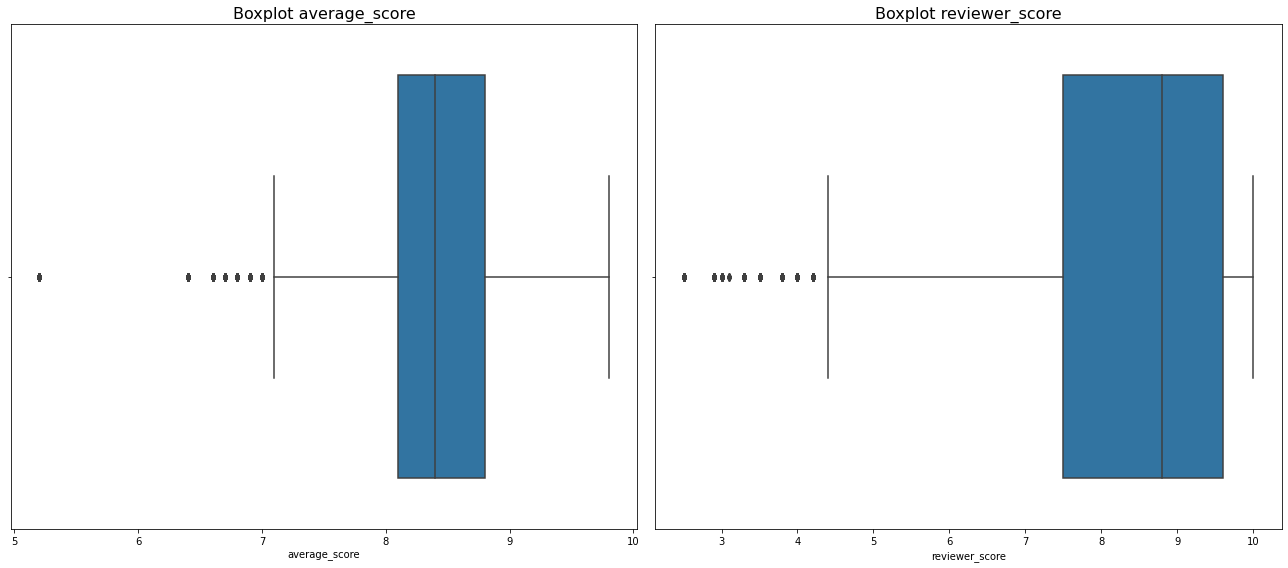

In [283]:
# посмотрим на выбросы в оценках
def print_plots(data):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    axes[0].ticklabel_format(style='plain', axis='x')

    avg_score = sns.boxplot(data=data, x='average_score', ax=axes[0])
    avg_score.set_title('Boxplot average_score', fontsize=16)
    avg_score.set_xlabel('average_score')

    axes[1].ticklabel_format(style='plain', axis='x')
    rev_score = sns.boxplot(data=data, x='reviewer_score', ax=axes[1])
    rev_score.set_title('Boxplot reviewer_score', fontsize=16)
    rev_score.set_xlabel('reviewer_score')

    plt.tight_layout()
    plt.show()

    
print_plots(df_train)

Видим что основные оценки расположены от 7 до 10, очистим выбросы с помощью поиска выбросов iqr-отклонения

Число выбросов по методу iqr отклонения для average_score: 7137
Число выбросов по методу iqr отклонения для reviewer_score: 10809


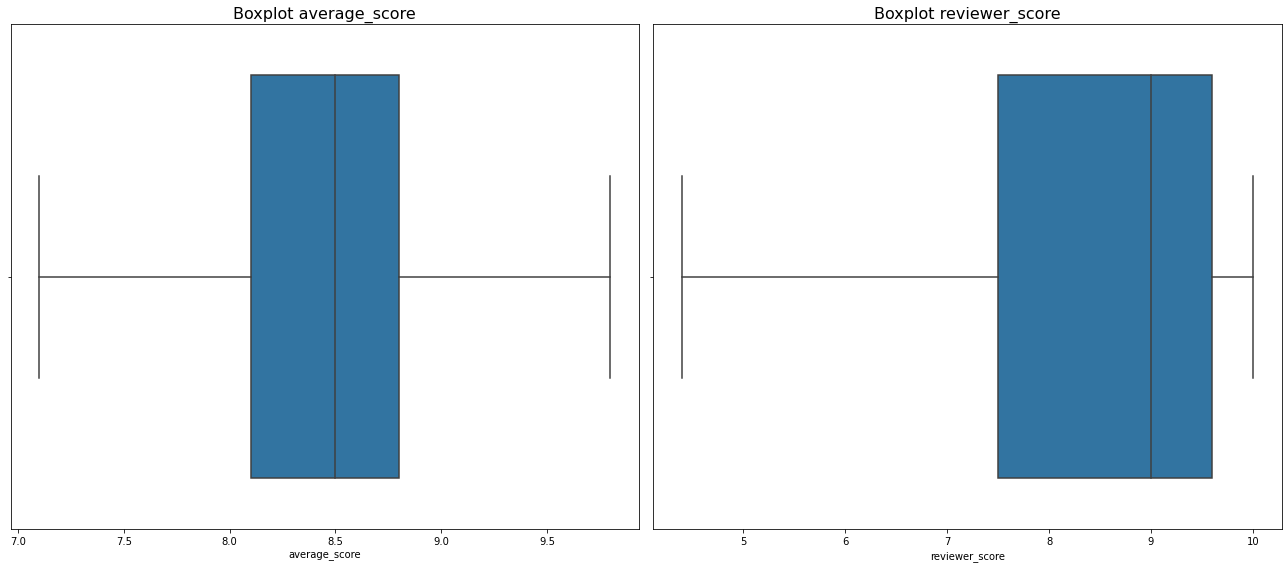

In [284]:
# с помощью метода поиска выбросов iqr-отклонения найдем и удалим выбросы по цене и пробегу
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
        
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    # удаляем выбросы
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

def add_outlier(data): 
    # по пробегу
    outliers_avg_score, cleaned = outliers_iqr_mod(data, 'average_score')
    print(f'Число выбросов по методу iqr отклонения для average_score: {outliers_avg_score.shape[0]}')

    outliers_rev_score, cleaned = outliers_iqr_mod(cleaned, 'reviewer_score')
    print(f'Число выбросов по методу iqr отклонения для reviewer_score: {outliers_rev_score.shape[0]}')

    print_plots(cleaned)
    return cleaned

df_train = add_outlier(df_train)

In [285]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_test, df_train], axis=0).reset_index(drop=True) # объединяем

In [286]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497485 entries, 0 to 497484
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               497485 non-null  object 
 1   additional_number_of_scoring                497485 non-null  int64  
 2   review_date                                 497485 non-null  object 
 3   average_score                               497485 non-null  float64
 4   hotel_name                                  497485 non-null  object 
 5   reviewer_nationality                        497485 non-null  object 
 6   negative_review                             497485 non-null  object 
 7   review_total_negative_word_counts           497485 non-null  int64  
 8   total_number_of_reviews                     497485 non-null  int64  
 9   positive_review                             497485 non-null  object 
 

In [287]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


In [288]:
data.describe(include='all')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
count,497485,497485.000000,497485,497485.000000,497485,497485,497485,497485.000000,497485.000000,497485,497485.000000,497485.000000,497485,497485,494297.000000,494297.000000,497485.000000,497485.000000
unique,1493,NaN,731,NaN,1492,226,314385,NaN,NaN,403497,NaN,NaN,54183,731,NaN,NaN,NaN,NaN
top,163 Marsh Wall Docklands Tower Hamlets London ...,NaN,8/2/2017,NaN,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,NaN,NaN,No Positive,NaN,NaN,"[' Leisure trip ', ' Couple ', ' Standard Doub...",1 days,NaN,NaN,NaN,NaN
freq,4257,NaN,2483,NaN,4257,236664,126639,NaN,NaN,32034,NaN,NaN,4792,2483,NaN,NaN,NaN,NaN
mean,NaN,498.026588,NaN,8.428073,NaN,NaN,NaN,17.725220,2737.927011,NaN,18.066356,7.217735,NaN,NaN,49.417498,2.850814,0.740826,6.350188
std,NaN,499.745862,NaN,0.515129,NaN,NaN,NaN,28.074714,2318.272989,NaN,21.897808,11.109232,NaN,NaN,3.481714,4.603583,0.438182,3.943647
min,NaN,1.000000,NaN,5.200000,NaN,NaN,NaN,0.000000,43.000000,NaN,0.000000,1.000000,NaN,NaN,41.328376,-0.369758,0.000000,0.000000
25%,NaN,168.000000,NaN,8.100000,NaN,NaN,NaN,0.000000,1158.000000,NaN,6.000000,1.000000,NaN,NaN,48.213425,-0.142613,0.000000,0.000000
50%,NaN,338.000000,NaN,8.500000,NaN,NaN,NaN,9.000000,2116.000000,NaN,11.000000,3.000000,NaN,NaN,51.499981,0.019886,1.000000,8.300000
75%,NaN,666.000000,NaN,8.800000,NaN,NaN,NaN,23.000000,3613.000000,NaN,23.000000,8.000000,NaN,NaN,51.516288,4.834443,1.000000,9.600000


**Вывод:** из полученных данных видим, что в датасете присутствуют пропущенные значения (признаки lat и lng),  кроме того в 8 признаках информация хранится в текстовом формате.

## 3. Подготовка данных

### Название и адрес отеля

Посмотрим есть ли одинаковые названия отелей в разных городах

In [289]:
name_address = data.pivot_table(
    values = 'hotel_address',
    index = 'hotel_name',
    aggfunc = 'nunique'
)

dupl = name_address[name_address['hotel_address'] > 1]
dupl

,hotel_address
hotel_name,
Hotel Regina,3


Cоздадим список, в котором будет храниться название отеля, имеющее несколько адресов, затем создадим уникальные названия отелей

In [290]:
dupl_list = dupl[dupl['hotel_address'] > 1].index.to_list()

def expand_hotel_name(name, address):
    if name in dupl_list:
        return name + ' in ' + address.split()[-1]
    
    return name

data['hotel_name'] = data.apply(lambda x: expand_hotel_name(x['hotel_name'], x['hotel_address']), axis=1)
data['hotel_name'].nunique()

1494

Так же из адреса можно выделить страну и город, где находяться отели

In [291]:
data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1])
data['country'] = data['country'].apply(lambda x:'United Kingdom' if x == 'Kingdom' else x)
print(list(data['country'].unique()))

data['country'] = data['country'].astype('category')
data['country_code'] = data['country'].cat.codes

['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France', 'Austria']


In [292]:
data['city'] = data['hotel_address'].apply(lambda x: x.split()[-2])
data['city'] = data['city'].apply(lambda x: 'London' if x == 'United' else x)
print(data['city'].unique())

data['city'] = data['city'].astype('category')
data['city_code'] = data['city'].cat.codes

['Milan' 'Amsterdam' 'Barcelona' 'London' 'Paris' 'Vienna']


А еще у нас есть координаты отеля, сами координаты скорее всего никак не влияют на отзыв, а вот удаленность от центра города, вполне. по этому найдем удаленность отелей от центра города с помощью библиотеки [geopy](https://pypi.org/project/geopy/) а координаты центров городов загуглим

In [293]:
def get_city_center_coords(city): 
    
    if city == 'London':
        coords = (51.509865, -0.118092)
    elif city == 'Paris':
        coords = (48.864716, 2.349014)
    elif city == 'Amsterdam':
        coords = (52.379189, 4.899431)
    elif city == 'Milan':
        coords = (45.464664, 9.188540)
    elif city == 'Vienna':
        coords = (48.210033, 16.363449)
    elif city == 'Barcelona':
        coords = (41.383785, 2.166775)
        
    return coords

def remoteness(lat1, long1, city):
    # помним что координаты содержат пропуски, по этому такие отели будем считать в самом центре города
    if np.isnan(lat1) or np.isnan(long1):
        coords_1 = get_city_center_coords(city)
    else:
        coords_1 = (lat1, long1)
         
    coords_2 = get_city_center_coords(city)
    
    remouteless = geopy.distance.distance(coords_1, coords_2).km
        
    return round(remouteless, 0)


data['remoute_from_center'] = data.apply(lambda x: remoteness(x['lat'], x['lng'], x['city']), axis=1)

# пропуски в данных заполним нулями
data['lat'] = data['lat'].fillna(0)
data['lng'] = data['lng'].fillna(0)

Посмотрим на среднюю оценку в зависимости от удаленности отеля

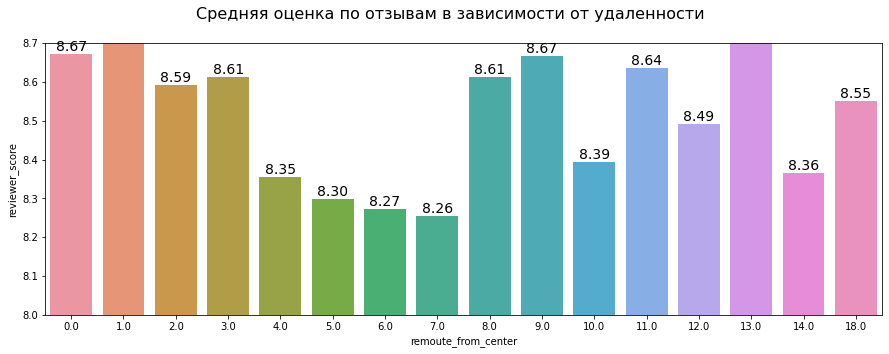

In [294]:
def avg_chart(data, column, title):
    hotels = data[data['sample'] == 1]
    pivotdata = hotels[[column, 'reviewer_score']].groupby(column).mean()
    fig5, ax5 = plt.subplots(figsize=(15, 5))
    plt.suptitle(title, size=16)
    bar_pivot = sns.barplot(
        x=pivotdata.index, 
        y=pivotdata['reviewer_score'])

    for p in bar_pivot.patches:
        bar_pivot.annotate('{:.2f}'.format(p.get_height()), 
                           (p.get_x()+0.4, p.get_height()),
                           ha='center', va='bottom', fontsize=14)

    plt.ylim(8, 8.7);
    

avg_chart(data, 'remoute_from_center', 'Средняя оценка по отзывам в зависимости от удаленности')

### Национальность респондента

Посмотрим, что можно получить из национальности ревьювера, для начала посмотрим сколько всего национальностей представлено:

In [295]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())
print(len(data["reviewer_nationality"].value_counts()))

226


In [296]:
print('Самые популярыне: {}'.format(list(data['reviewer_nationality'].value_counts(ascending=False)[:50].index)))

Самые популярыне: ['United Kingdom', 'United States of America', 'Australia', 'Ireland', 'United Arab Emirates', 'Saudi Arabia', 'Netherlands', 'Switzerland', 'Canada', 'Germany', 'France', 'Israel', 'Italy', 'Belgium', 'Turkey', 'Kuwait', 'Spain', 'Romania', 'Russia', 'South Africa', 'China', 'Greece', 'Sweden', 'India', 'New Zealand', 'Singapore', 'Hong Kong', 'Poland', 'Qatar', 'Austria', 'Norway', 'Egypt', 'Czech Republic', 'Lebanon', 'Hungary', 'Malaysia', 'Thailand', 'Brazil', 'Finland', 'Portugal', 'Denmark', 'Malta', 'Bahrain', 'Indonesia', 'Cyprus', 'Luxembourg', 'Croatia', 'Oman', 'Bulgaria', 'Japan']


Скорее всего сама национальность не влияет на отзыв, а влияет языковая среда, выделим несоклько языковых групп: английскую, немецкую, испанскую, арабскую, индо-китайскую, славянскую и другие

In [297]:
def lang_types(current_type):
    english_list = ['United Kingdom', 'United States of America', 'Australia', 'Canada', 'New Zealand', 'Ireland', 'South Africa']
    german_list = ['Germany', 'Belgium', 'Netherlands', 'Switzerland', 'Austria', 'Norway', 'Denmark', 'Sweden', 'Finland']
    arabian_list = ['United Arab Emirates', 'Saudi Arabia', 'Turkey', 'Kuwait', 'Qatar', 'Oman', 'Israel', 'Bahrain', 'Egypt', 'Lebanon']
    china_list = ['China', 'Thailand', 'Singapore', 'Hong Kong', 'Austria', 'Portugal', 'Japan', 'Indonesia', 'India', 'Malaysia']
    spain_list = ['Portugal', 'Spain', 'Brazil', 'Romania', 'Portugal', 'Italy', 'Greece', 'Cyprus', 'Malta']
    italy_list = ['Italy', 'Malta']
    greek_list = ['Greece', 'Cyprus']
    france_list = ['France']
    russian_list = ['Russia']
    west_europe_list = ['Bulgaria', 'Poland', 'Romania', 'Czech Republic', 'Hungary']
    
    if current_type in english_list:
        return 'english'

    if current_type in german_list:
        return 'german'
    
    if current_type in china_list:
        return 'china'
    
    if current_type in spain_list:
        return 'spain'
    
    if current_type in russian_list:
        return 'russian'
    
    if current_type in greek_list:
        return 'greek'
    
    if current_type in italy_list:
        return 'italy'
    
    if current_type in france_list:
        return 'france'
    
    if current_type in west_europe_list:
        return 'west_europe'
    
    return 'other'

data['lang_type'] = data['reviewer_nationality'].apply(lang_types).astype('category')
data['lang_type_code'] = data['lang_type'].cat.codes

data['reviewer_nationality'] = data['reviewer_nationality'].astype('category')
data['reviewer_nationality_code'] = data['reviewer_nationality'].cat.codes

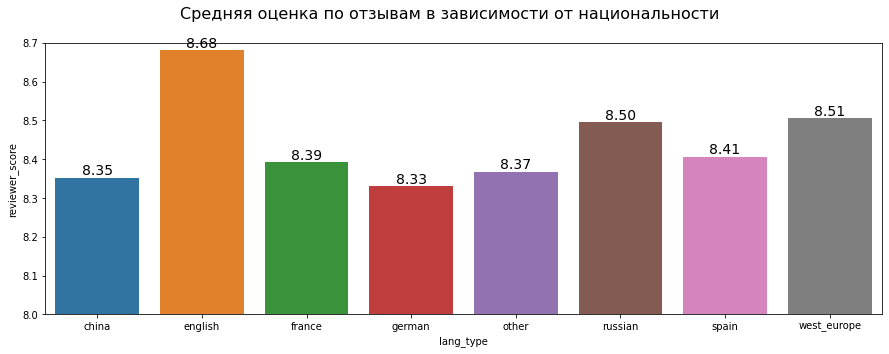

In [298]:
avg_chart(data, 'lang_type', 'Средняя оценка по отзывам в зависимости от национальности')


### Теги

Взглянем на теги, но для начала надо привести поле из строкового в список

In [299]:
data['tags'] = data['tags'].apply(lambda x: json.loads(x.replace("' ", '"').replace(" '", '"')))

In [300]:
all_tags = [*itertools.chain.from_iterable(data['tags'])]

Нарисуем облако тегов

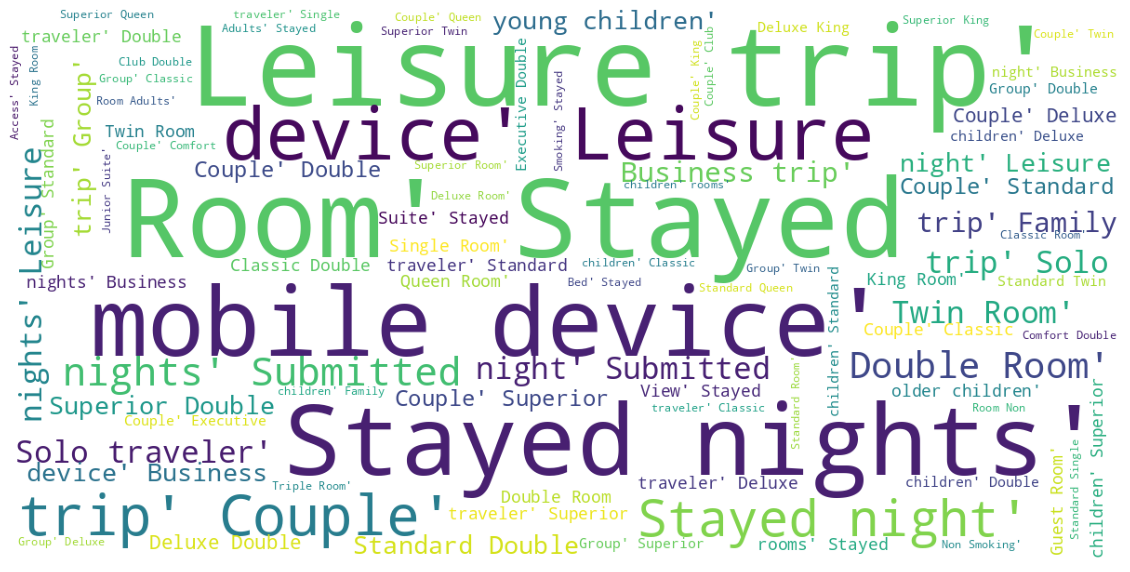

In [301]:
def show_wordcloud(data, background_color, colormap):
    """Рисуем облако слов с заданными параметрами."""
    wordcloud = WordCloud(
        background_color = background_color,
        colormap = colormap,
        max_font_size = 40,
        max_words=100,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(all_tags, 'white', 'viridis')

Из тегов можно выделить признак количество проведенных ревьювером ночей в отеле, а так же тип номера

In [302]:
def count_nights(tags):
    matches = re.findall(r'Stayed\s\d+\snight', ','.join(map(str, tags)))
    cnt_nughts = 1
    for num in matches:
        cnt_nughts = np.int32(re.sub(r'\D+', '', num))
    return cnt_nughts

data['count_nights'] = data['tags'].apply(count_nights).convert_dtypes().fillna(1)

def room_type(tags):
    type = 'Standard Room'
    for tag in tags:
        matches = re.findall(r'\w.*Room', tag)
        if matches:
            type = matches[0]
    return type

data['room_type'] = data['tags'].apply(room_type).fillna('Standard Room')


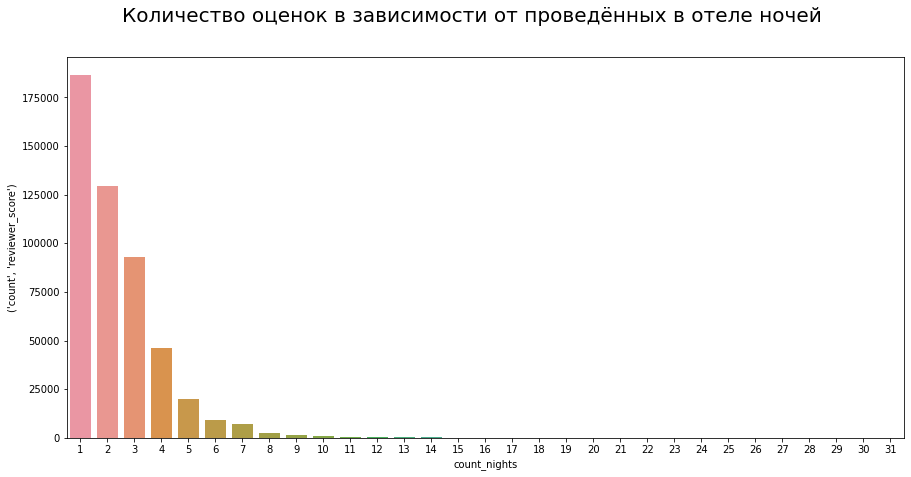

In [303]:
def tags_chart(data, column, title):
    pivot_nights = pd.pivot_table(
        data=data,
        index=column, 
        values='reviewer_score', 
        aggfunc=['count', 'mean'])
    fig1, ax1 = plt.subplots(figsize=(15, 7))
    plt.suptitle(title, size=20)
    sns.barplot(x=pivot_nights.index, y=pivot_nights[('count', 'reviewer_score')]);
    
tags_chart(data, 'count_nights', 'Количество оценок в зависимости от проведённых в отеле ночей')

Взглянем на типы номеров

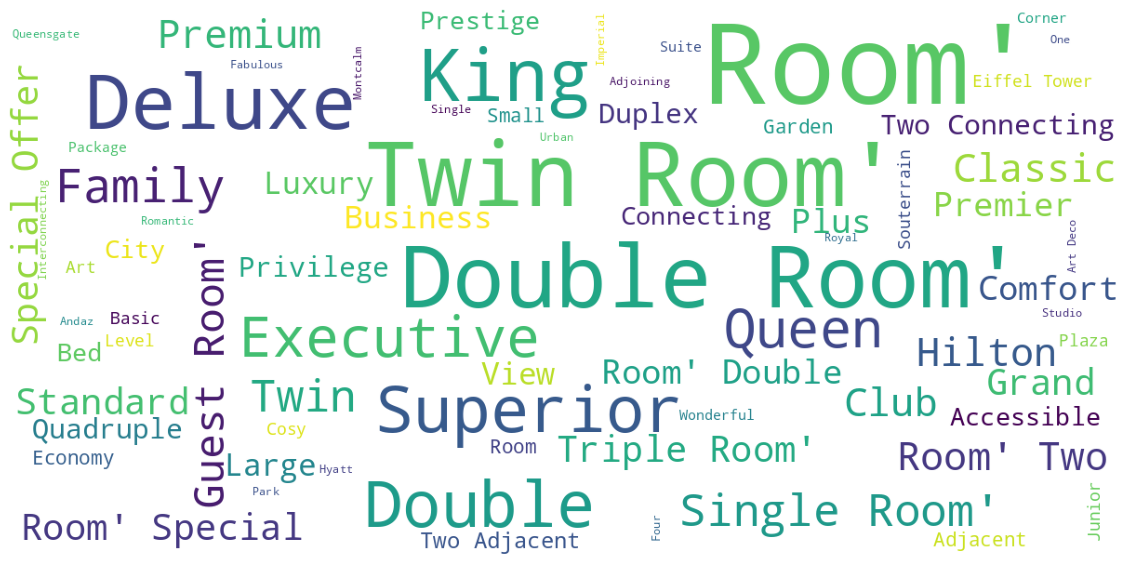

In [304]:

show_wordcloud(data['room_type'].unique(), 'white', 'viridis')

Видно, что типов получилось слишком много, нужно их сократить

In [305]:
def cleaer_room_types(current_type):
    
    if 'Guestroom' in current_type:
        return 'Guestroom'

    if 'Offer' in current_type:
        return 'Offer'
    
    if 'Comfort' in current_type:
        return 'Comfort'
    
    if 'Suite' in current_type  or 'Large' in current_type or \
    'Deluxe' in current_type or 'Premier' in current_type or \
    'Superior' in current_type or 'Buisness' in current_type:
        return 'Deluxe'
    
    if 'Queen' in current_type or 'Grand' in current_type or \
    'Hilton' in current_type or 'King' in current_type or \
    'Luxury' in current_type or 'Privilege' in current_type:
        return 'Luxe'

    if 'Double' in current_type or 'Twin' in current_type or 'Duplex' in current_type:
        return 'Double'
    
    if 'Triple' in current_type or 'Family' in current_type or \
    'Quadruple' in current_type or 'Club' in current_type:
        return 'Triple'
    
    if 'Classic' in current_type or 'Studio' in current_type or 'Standard' in current_type:
        return 'Standard'
    
    if 'Single' in current_type:
        return 'Single'
    
    if 'Small' in current_type or 'Bed' in current_type or 'Economy' in current_type:
        return 'Economy'
    
    return None

data['room_type'] = data['room_type'].apply(cleaer_room_types).fillna('Other').astype('category')

data['room_type_code'] = data['room_type'].cat.codes
data['room_type'].value_counts()

Double      210678
Deluxe      144567
Standard     65288
Luxe         39403
Triple       13467
Single       11180
Comfort       7595
Other         4205
Offer         1018
Economy         84
Name: room_type, dtype: int64

In [306]:
hotels = data[data['sample'] == 1]

Посмотрим распределение средней оценки в зависимости от типа комнаты

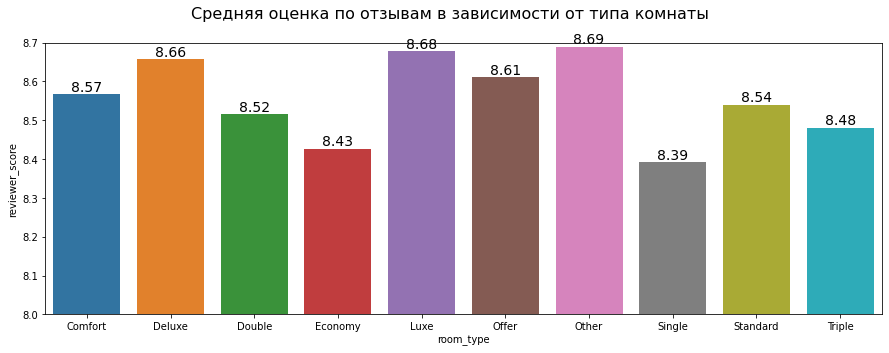

In [307]:
avg_chart(data, 'room_type', 'Средняя оценка по отзывам в зависимости от типа комнаты')

Так же можно выделить тип гостя и цель поездки

In [308]:
def guest_types(tags):
    type = None
    for tag in tags:
        if 'Couple' in tag:
            type = 'Couple'
        if 'Family' in tag:
            type = 'Family'   
        if 'children' in tag:
            type = 'Children'   
        if 'traveler' in tag:
            type = 'Traveler'  
        if 'Group' in tag:
            type = 'Group'
        if 'Smoking' in tag:
            type = 'Smoking'
    
    return type

data['guest_types'] = data['tags'].apply(guest_types).fillna('Other').astype('category')

data['guest_types_code'] = data['guest_types'].cat.codes
data['guest_types'].value_counts()

Couple      242201
Traveler    102016
Children     77077
Group        61553
Family        8344
Smoking       4287
Other         2007
Name: guest_types, dtype: int64

In [309]:

def trip_types(tags):
    type = None
    for tag in tags:
        if 'Leisure trip' in tag:
            type = 'Leisure'
        if 'Business trip' in tag:
            type = 'Business'
    return type


data['trip_types'] = data['tags'].apply(trip_types).fillna('Other').astype('category')

data['trip_types_code'] = data['trip_types'].cat.codes
data['trip_types'].value_counts()

Leisure     404920
Business     78394
Other        14171
Name: trip_types, dtype: int64

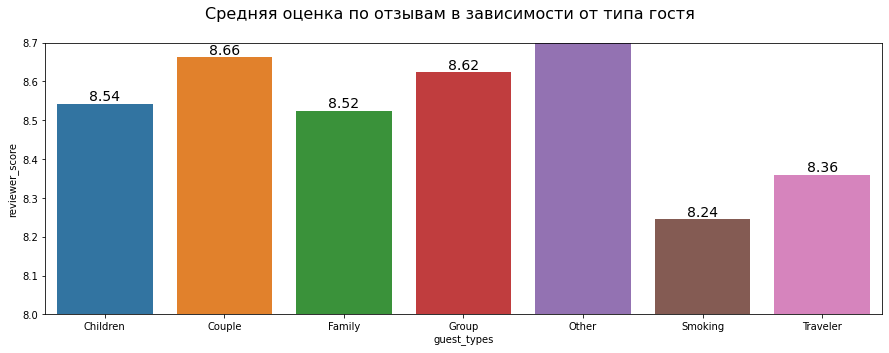

In [310]:
avg_chart(data, 'guest_types', 'Средняя оценка по отзывам в зависимости от типа гостя')

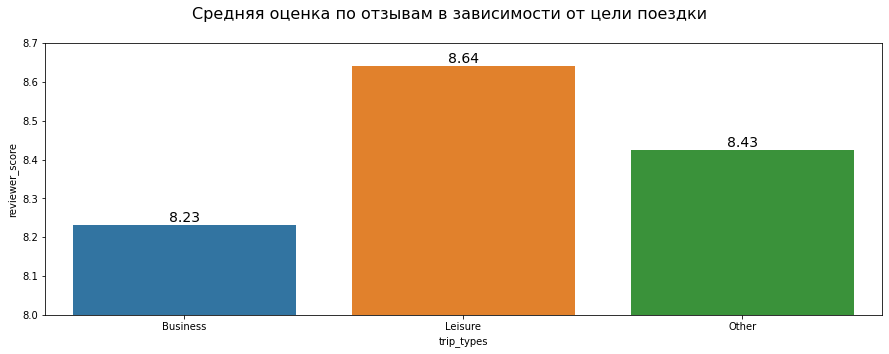

In [311]:
avg_chart(data, 'trip_types', 'Средняя оценка по отзывам в зависимости от цели поездки')

### Текст отзыва


- Отрицательный отзыв, который рецензент дал отелю ('negative_review')
- Положительный отзыв, который рецензент дал отелю ('positive_review')
- Общее количество слов в отрицательном отзыве ('review_total_negative_word_counts')
- Общее количество слов в положительном отзыве ('review_total_positive_word_counts')

Скорее всего количество слов в отзыве прямо связано с его негативностью, т.е. если респонеденту все понравилось, вероятнее всего он просто поставит оценку и напишет отзыв из 2-3х слов, а если что-то не понравилось, то он подробно это распишет. По этому стоит проверить эту взаимосвязь

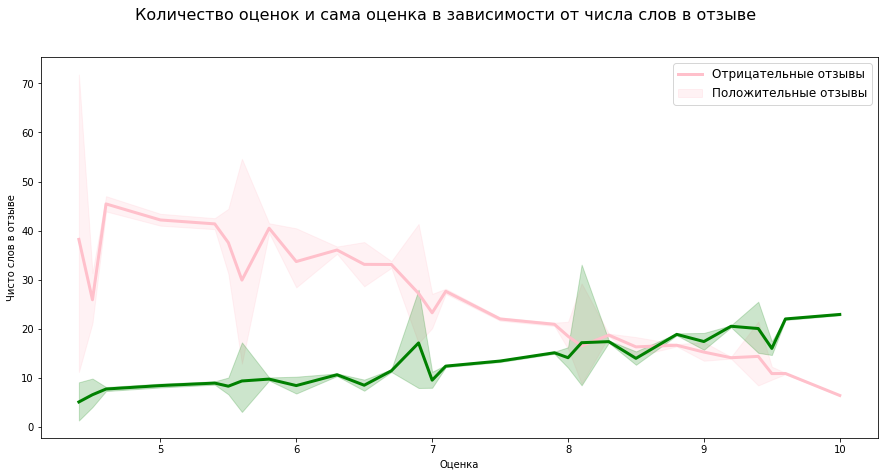

In [312]:
# Проверим наше предположение
fig3, ax3 = plt.subplots(figsize=(15, 7))
plt.suptitle('Количество оценок и сама оценка в зависимости от числа слов в отзыве', size=16)
negative = sns.lineplot(
    data=hotels,
    x='reviewer_score',
    y='review_total_negative_word_counts',
    color='pink', linewidth=3
)
positive = sns.lineplot(
    data=hotels,
    x='reviewer_score',
    y='review_total_positive_word_counts',
    color='green', linewidth=3
)
ax3.set_xlabel('Оценка')
ax3.set_ylabel('Чисто слов в отзыве')
ax3.legend(['Отрицательные отзывы', 'Положительные отзывы'], loc='upper right', fontsize=12);

На графике видно, что для отрицательных отзывов: чем меньше оценка, тем больше слов в отзыве (что логично)

Посчитаем пропроцию негативных и положительных отзывов

In [313]:
data['review_total_word_sum'] = data['review_total_positive_word_counts'] + \
    data['review_total_negative_word_counts']

# пополам отрицательных и положительных
data['positive_words_proportion'] = data.apply(lambda x: 0.5 if x['review_total_word_sum'] == 0 \
                                               else x['review_total_positive_word_counts'] / x['review_total_word_sum'],axis=1)


In [314]:
# для нормализации количества комментариев респондента, логорифмируем
data['total_number_of_reviews_reviewer_has_given'] = data['total_number_of_reviews_reviewer_has_given'].apply(lambda x: np.log(x+1))

data['total_number_of_reviews_reviewer_has_given']

0         0.693147
1         2.079442
2         2.772589
3         2.302585
4         1.098612
            ...   
497480    1.386294
497481    2.397895
497482    0.693147
497483    3.367296
497484    1.098612
Name: total_number_of_reviews_reviewer_has_given, Length: 497485, dtype: float64

Посмотрим распределение количества слов в негативных и положительных оценках

In [315]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score,...,city_code,remoute_from_center,lang_type_code,reviewer_nationality_code,count_nights,room_type_code,guest_types_code,trip_types_code,review_total_word_sum,positive_words_proportion
count,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,...,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000
mean,498.026588,8.428073,17.725220,2737.927011,18.066356,1.632580,49.100819,2.832545,0.740826,6.350188,...,2.196221,3.202267,1.934653,166.754393,2.363768,2.966670,2.181185,0.870905,35.791576,0.576265
std,499.745862,0.515129,28.074714,2318.272989,21.897808,0.893039,5.252987,4.594444,0.438182,3.943647,...,1.324269,2.636193,1.640983,66.426727,1.642268,2.549634,2.138271,0.411583,37.901217,0.333504
min,1.000000,5.200000,0.000000,43.000000,0.000000,0.693147,0.000000,-0.369758,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,168.000000,8.100000,0.000000,1158.000000,6.000000,0.693147,48.211084,-0.142448,0.000000,0.000000,...,2.000000,1.000000,1.000000,110.000000,1.000000,1.000000,1.000000,1.000000,13.000000,0.305556
50%,338.000000,8.500000,9.000000,2116.000000,11.000000,1.386294,51.499393,0.000000,1.000000,8.300000,...,2.000000,3.000000,1.000000,213.000000,2.000000,2.000000,1.000000,1.000000,24.000000,0.555556
75%,666.000000,8.800000,23.000000,3613.000000,23.000000,2.197225,51.516191,4.831098,1.000000,9.600000,...,3.000000,4.000000,3.000000,213.000000,3.000000,4.000000,3.000000,1.000000,45.000000,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,5.874931,52.400181,16.429233,1.000000,10.000000,...,5.000000,18.000000,7.000000,225.000000,31.000000,9.000000,6.000000,2.000000,737.000000,1.000000


Из полученных данных видим, что наиболее высокое стандартное отклонение имеют признаки review_total_positive_word_counts, review_total_negative_word_counts, additional_number_of_scoring, total_number_of_reviews. Построим график kdeplot для данных признаков.

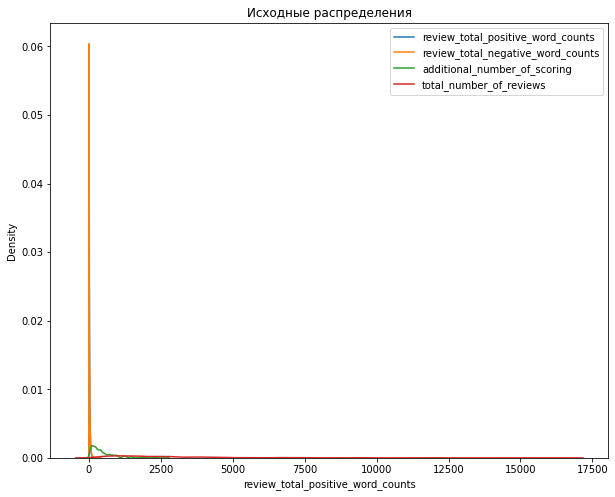

In [316]:
def allocation_chart(data, col_names, title):
    fig = plt.figure(figsize=(10, 8))

    for col in col_names:
        kde = sns.kdeplot(data[col], label =col)

    kde.set_title(title)
    plt.legend();
    
col_names = ['review_total_positive_word_counts', 'review_total_negative_word_counts',
    'additional_number_of_scoring', 'total_number_of_reviews']

allocation_chart(data, col_names, 'Исходные распределения')

Из графика видим, что указанные признаки имеют распределения отличные от нормального, поэтому произведем нормализацию данных признаков используя MinMaxScaler

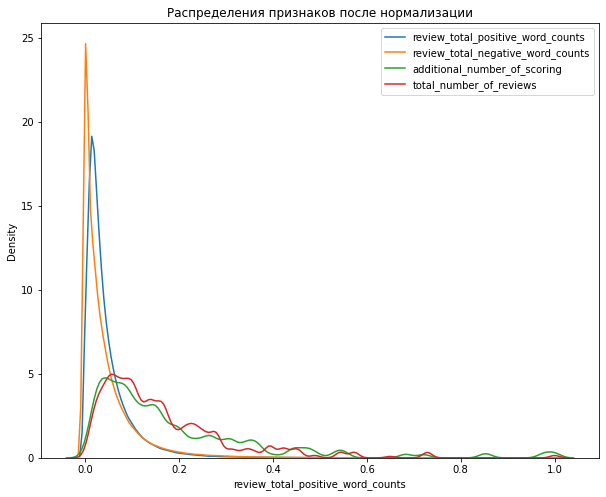

In [317]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# Осуществляем нормализацию признааков.
data_mm = mm_scaler.fit_transform(data[col_names])

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
data_mm = pd.DataFrame(data_mm, columns=col_names)

allocation_chart(data_mm, col_names, 'Распределения признаков после нормализации')

for col in col_names:
    data[col] = data_mm[col]

In [318]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497485 entries, 0 to 497484
Data columns (total 35 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               497485 non-null  object  
 1   additional_number_of_scoring                497485 non-null  float64 
 2   review_date                                 497485 non-null  object  
 3   average_score                               497485 non-null  float64 
 4   hotel_name                                  497485 non-null  object  
 5   reviewer_nationality                        497485 non-null  category
 6   negative_review                             497485 non-null  object  
 7   review_total_negative_word_counts           497485 non-null  float64 
 8   total_number_of_reviews                     497485 non-null  float64 
 9   positive_review                             497485 non-null

Проведем сентимент-анализ положительных и отрицательных отзывов для получения оценки полярности каждого отзыва с помощью методов NLP. 

In [319]:
# Создаем объект класса.
sent_analyzer = SentimentIntensityAnalyzer()

# Оцениваем полярность негативных отзывов.
data['negative_review_score'] = data['negative_review'].apply(
    lambda x: 0 if x == 'No Negative' else sent_analyzer.polarity_scores(x)['compound']
)

# Оцениваем полярность положительных отзывов.
data['positive_review_score'] = data['positive_review'].apply(
    lambda x: 0 if x == 'No Positive' else sent_analyzer.polarity_scores(x)['compound']
)

data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,room_type,room_type_code,guest_types,guest_types_code,trip_types,trip_types_code,review_total_word_sum,positive_words_proportion,negative_review_score,positive_review_score
0,Via Senigallia 6 20161 Milan Italy,0.336815,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,0.127451,1.000000,Hotel was great clean friendly staff free bre...,...,Double,2,Couple,1,Leisure,1,114,0.54386,-0.0554,0.9615
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,0.227900,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,0.024510,0.299212,No Positive,...,Triple,9,Group,3,Leisure,1,10,0.00000,-0.2960,0.0000
2,Mallorca 251 Eixample 08008 Barcelona Spain,0.016785,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,0.007353,0.018524,Nice welcoming and service,...,Double,2,Traveler,6,Business,0,8,0.62500,0.0000,0.6908
3,Piazza Della Repubblica 17 Central Station 201...,0.089519,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0.000000,0.090215,Everything including the nice upgrade The Hot...,...,Standard,8,Couple,1,Leisure,1,27,1.00000,0.0000,0.9153
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,0.310705,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0.000000,0.279305,Lovely hotel v welcoming staff,...,Double,2,Traveler,6,Business,0,7,1.00000,0.0000,0.7717


### Дата отызва

Преобразуем признак review_date	в тип datetime. Дополнительно добавим призкак review_month.

In [320]:
data['review_date'] = pd.to_datetime(data['review_date'], format='%m/%d/%Y')

# Добавим дополнительные признаки.
data['review_month'] = data['review_date'].dt.month
data['review_year'] = data['review_date'].dt.year

# Преобразуем days_since_review в числовой признак.
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))

Посмотрим распределение средней оценки по месяцам

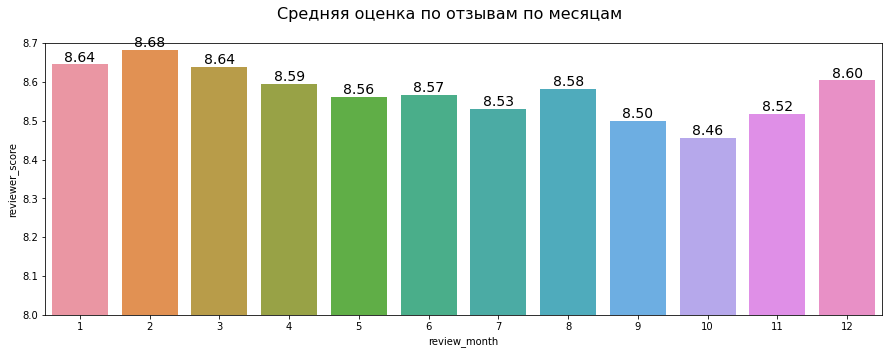

In [321]:
avg_chart(data, 'review_month', 'Средняя оценка по отзывам по месяцам')

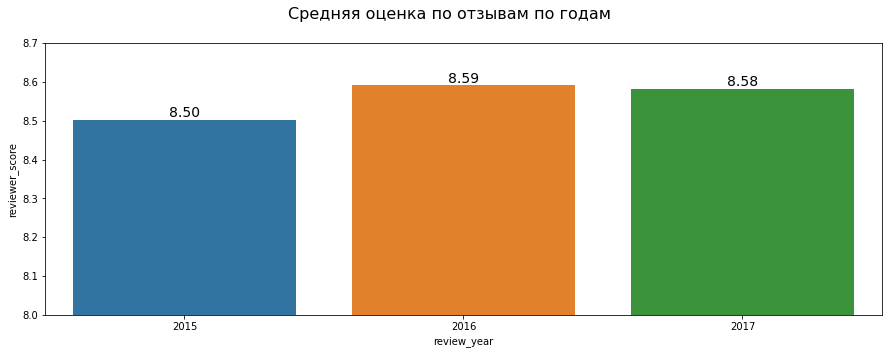

In [322]:
avg_chart(data, 'review_year', 'Средняя оценка по отзывам по годам')

## Мультиколлениарность

Выполним проверку числовых признаков на наличие мультиколлениарности, для этого построим матрицу корреляции.
Но перед этим удалим не числовые столбцы

In [323]:
# убираем признаки которые еще не успели обработать, 
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

cat_date_columns = [cd for cd in data.columns if ((data[cd].dtypes.name == 'category') or (data[cd].dtypes == 'datetime64[ns]'))]
data.drop(cat_date_columns, axis = 1, inplace=True)


In [324]:
data.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'sample', 'reviewer_score', 'country_code', 'city_code',
       'remoute_from_center', 'lang_type_code', 'reviewer_nationality_code',
       'count_nights', 'room_type_code', 'guest_types_code', 'trip_types_code',
       'review_total_word_sum', 'positive_words_proportion',
       'negative_review_score', 'positive_review_score', 'review_month',
       'review_year'],
      dtype='object')

In [325]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 
            'total_number_of_reviews_reviewer_has_given', 'review_total_positive_word_counts', 
            'days_since_review', 'review_total_word_sum', 'positive_words_proportion']

# категориальные признаки
cat_cols = ['average_score', 'additional_number_of_scoring', 'review_month', 'review_year',
            'guest_types_code', 'trip_types_code', 'lat', 'lng', 
            'negative_review_score', 'positive_review_score', 
            'count_nights', 'lang_type_code', 'reviewer_nationality_code',
            'country_code', 'city_code', 'room_type_code', 'remoute_from_center']

hotels = data.drop(['sample'], axis=1)

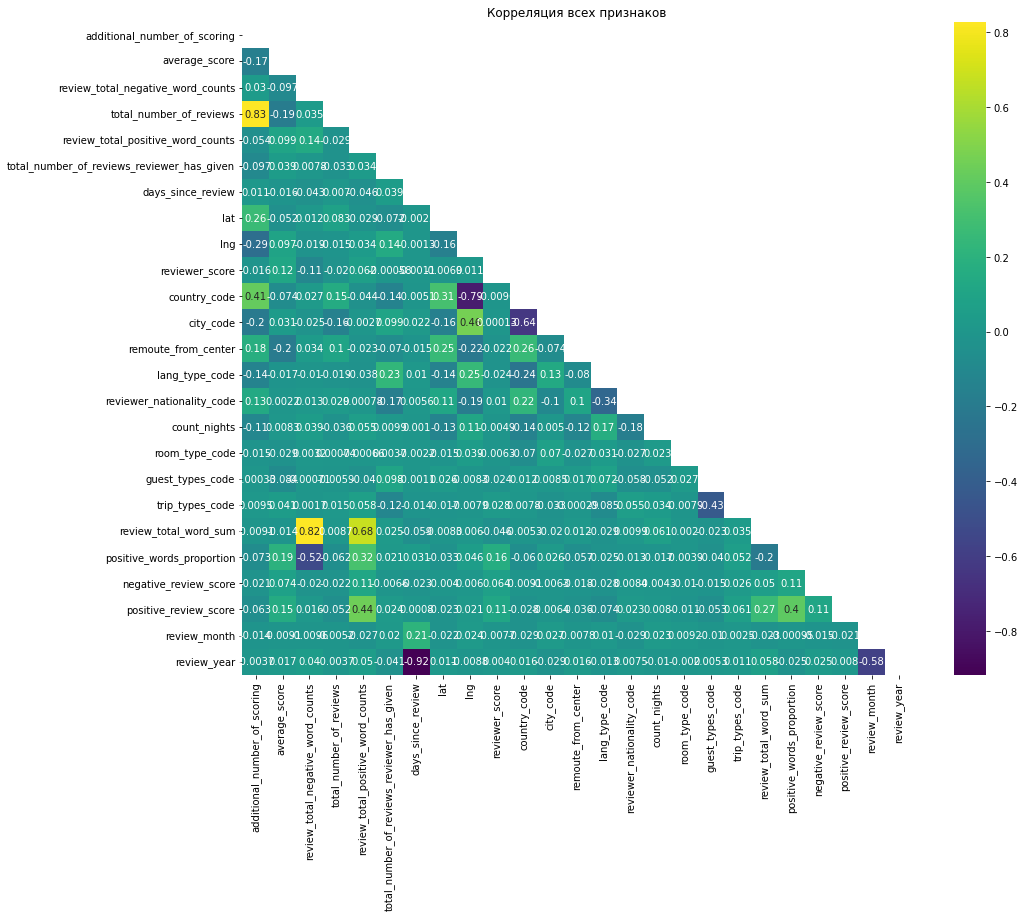

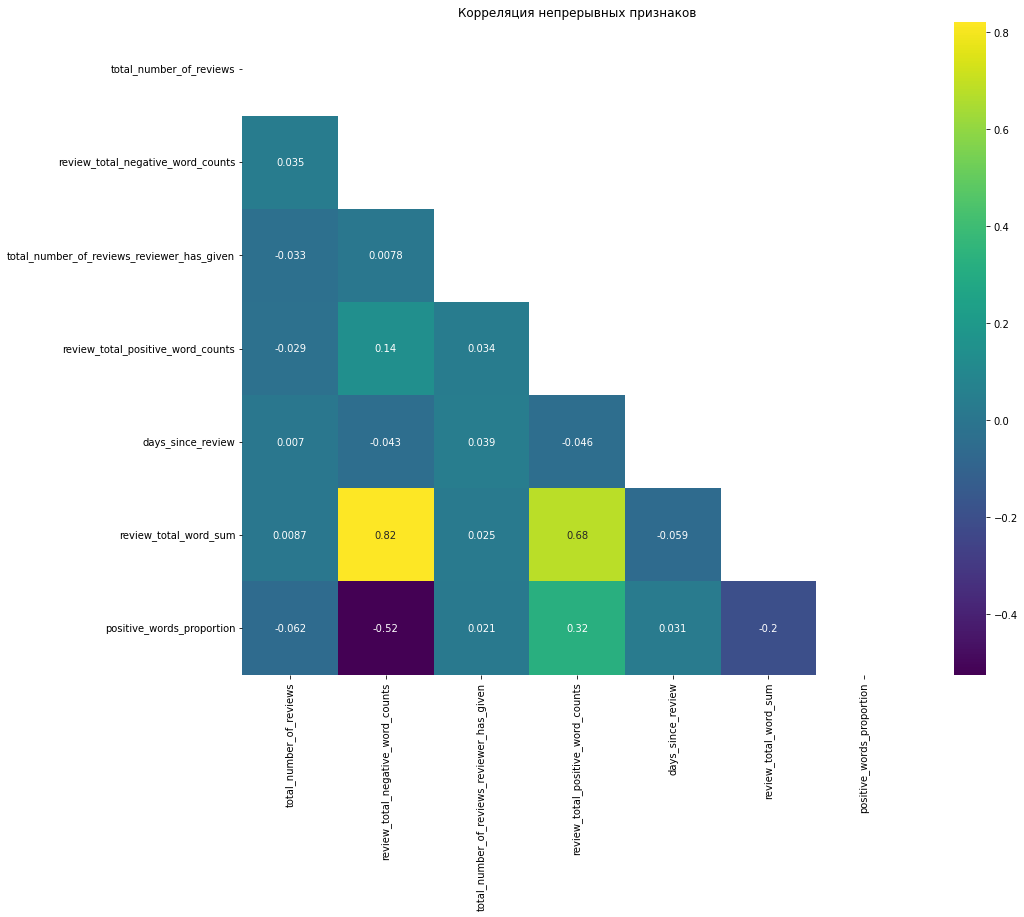

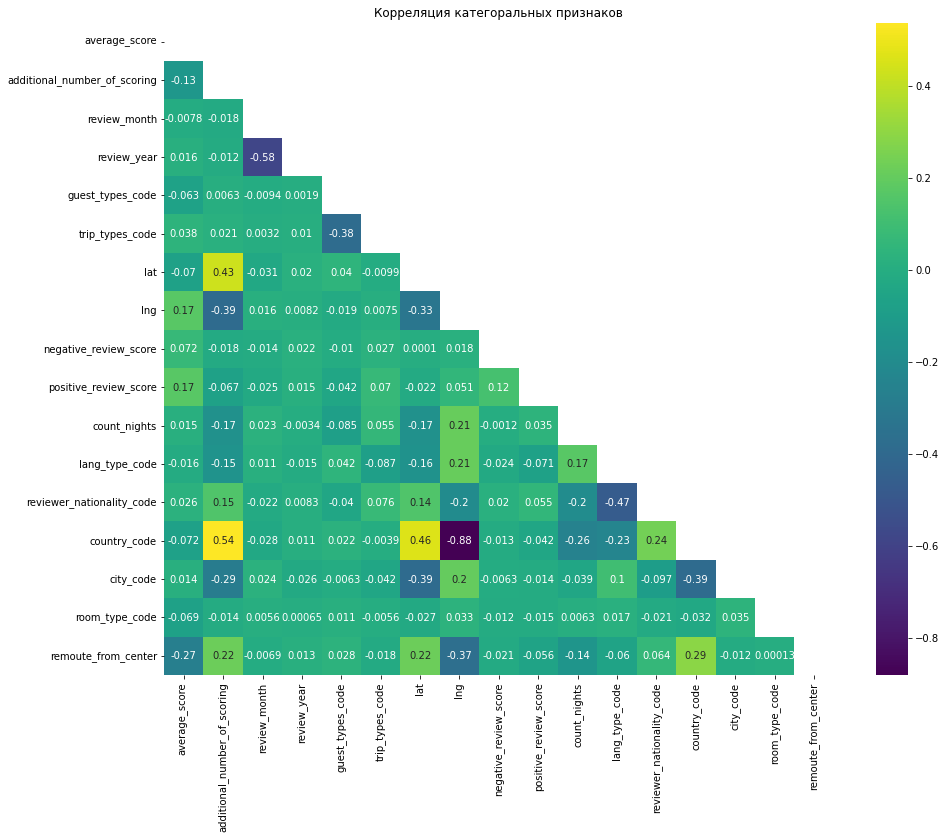

In [326]:
def corr_chart(data, columns, corr_type='pearson', title='Корреляция'):
    fig = plt.subplots(figsize=(15, 12))
    corr = data[columns].corr(method=corr_type)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    heatmap = sns.heatmap(corr, annot=True, mask=mask, cmap='viridis')
    heatmap.set_title(title);
    plt.show()

corr_chart(hotels, hotels.columns, 'pearson', 'Корреляция всех признаков')
    
corr_chart(hotels, num_cols, 'pearson', 'Корреляция непрерывных признаков')
    
corr_chart(hotels, cat_cols, 'spearman', 'Корреляция категоральных признаков')


Из полученного графика видим, что между признаками additional_number_of_scoring и total_number_of_reviews присутствует сильная связь, поэтому удалим один из них, 
еще между review_total_word_sum и review_total_negative_word_counts,
так же сильная связь между lng и country_code, но для начала проверим значимость этих признаков

### ОЦЕНКА ЗНАЧИМОСТИ ПРИЗНАКОВ

Для оценки значимости категориальных переменных будем использовать изученный нами непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2. Метод возвращает массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике:

In [327]:
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,count_nights,room_type_code,guest_types_code,trip_types_code,review_total_word_sum,positive_words_proportion,negative_review_score,positive_review_score,review_month,review_year
count,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,...,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000,497485.000000
mean,0.185389,8.428073,0.043444,0.162081,0.045738,1.632580,354.666788,49.100819,2.832545,6.350188,...,2.363768,2.966670,2.181185,0.870905,35.791576,0.576265,-0.019583,0.582396,6.481611,2016.120560
std,0.186403,0.515129,0.068811,0.139428,0.055437,0.893039,208.766387,5.252987,4.594444,3.943647,...,1.642268,2.549634,2.138271,0.411583,37.901217,0.333504,0.345447,0.363015,3.352857,0.686969
min,0.000000,5.200000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,-0.369758,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.997000,-0.983200,1.000000,2015.000000
25%,0.062290,8.100000,0.000000,0.067060,0.015190,0.693147,176.000000,48.211084,-0.142448,0.000000,...,1.000000,1.000000,1.000000,1.000000,13.000000,0.305556,-0.108200,0.401900,4.000000,2016.000000
50%,0.125699,8.500000,0.022059,0.124677,0.027848,1.386294,353.000000,51.499393,0.000000,8.300000,...,2.000000,2.000000,1.000000,1.000000,24.000000,0.555556,0.000000,0.718400,7.000000,2016.000000
75%,0.248042,8.800000,0.056373,0.214711,0.058228,2.197225,527.000000,51.516191,4.831098,9.600000,...,3.000000,4.000000,3.000000,1.000000,45.000000,1.000000,0.000000,0.886000,9.000000,2017.000000
max,1.000000,9.800000,1.000000,1.000000,1.000000,5.874931,730.000000,52.400181,16.429233,10.000000,...,31.000000,9.000000,6.000000,2.000000,737.000000,1.000000,0.996000,0.999300,12.000000,2017.000000


<AxesSubplot:>

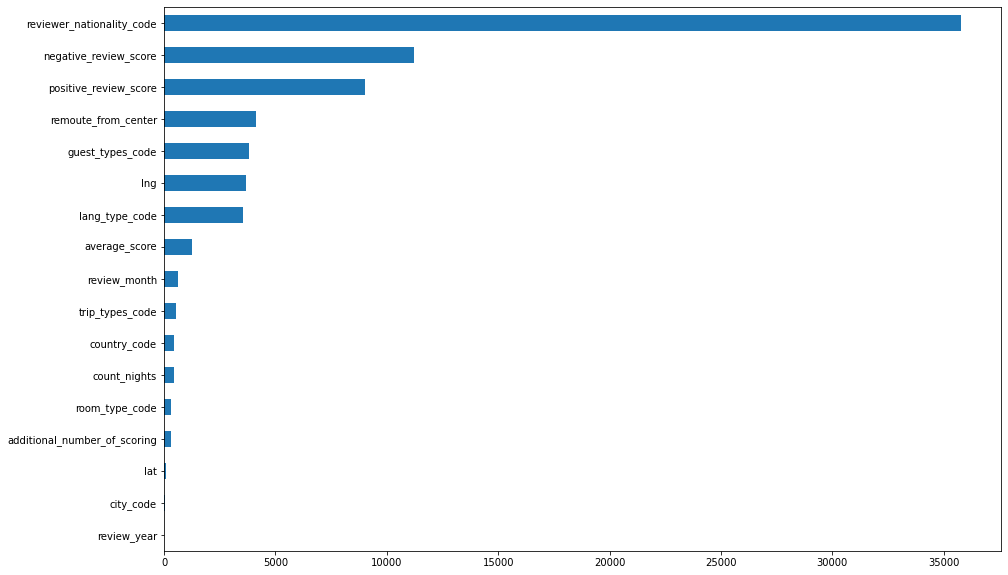

In [328]:
y = hotels['reviewer_score']
hotels.drop(['reviewer_score'], axis = 1, inplace=True) 
y=y.astype('int')

# хи-квадрат работает только с положительными значениями
hotels['lng'] = hotels['lng'].apply(lambda x: x if x > 0 else x * -1)
hotels['negative_review_score'] = hotels['negative_review_score'].apply(lambda x: x if x > 0 else x * -1)
hotels['positive_review_score'] = hotels['positive_review_score'].apply(lambda x: x if x > 0 else x * -1)

imp_num = pd.Series(chi2(hotels[cat_cols], y)[0], index = cat_cols)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 10))
imp_num.plot(kind = 'barh')

<AxesSubplot:>

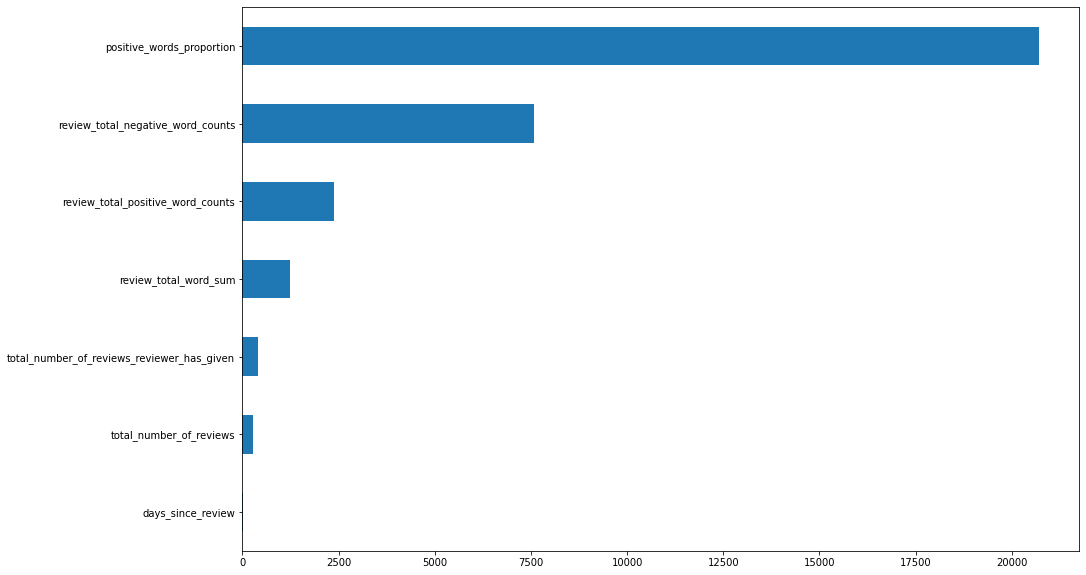

In [329]:
# Влияние числовых признаков.  
plt.rcParams['figure.figsize'] = (15,10)
imp_num = pd.Series(f_classif(hotels[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

На графиках видно, что days_since_review, total_number_of_reviews, lat, city_code не оказывает никакого влияния, а так же помним, что lng сильно свзяано с country_code по этому удалим столбцы

In [330]:
data.drop(['lat', 'lng', 'days_since_review', 'city_code', 'total_number_of_reviews'], axis=1, inplace=True)

In [331]:
data.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,sample,reviewer_score,country_code,remoute_from_center,lang_type_code,...,count_nights,room_type_code,guest_types_code,trip_types_code,review_total_word_sum,positive_words_proportion,negative_review_score,positive_review_score,review_month,review_year
0,0.336815,8.1,0.127451,0.156962,0.693147,0,0.0,2,8.0,1,...,2,2,1,1,114,0.54386,-0.0554,0.9615,7,2017
1,0.227900,8.6,0.024510,0.000000,2.079442,0,0.0,3,4.0,3,...,1,9,3,1,10,0.00000,-0.2960,0.0000,12,2016
2,0.016785,8.3,0.007353,0.012658,2.772589,0,0.0,4,1.0,3,...,1,2,6,0,8,0.62500,0.0000,0.6908,11,2015
3,0.089519,9.1,0.000000,0.068354,2.302585,0,0.0,2,2.0,1,...,1,8,1,1,27,1.00000,0.0000,0.9153,10,2015
4,0.310705,9.1,0.000000,0.017722,1.098612,0,0.0,3,1.0,1,...,2,2,6,0,7,1.00000,0.0000,0.7717,5,2016


In [332]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497485 entries, 0 to 497484
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                497485 non-null  float64
 1   average_score                               497485 non-null  float64
 2   review_total_negative_word_counts           497485 non-null  float64
 3   review_total_positive_word_counts           497485 non-null  float64
 4   total_number_of_reviews_reviewer_has_given  497485 non-null  float64
 5   sample                                      497485 non-null  int64  
 6   reviewer_score                              497485 non-null  float64
 7   country_code                                497485 non-null  int8   
 8   remoute_from_center                         497485 non-null  float64
 9   lang_type_code                              497485 non-null  int8   
 

# 4.Построение модели

In [333]:
# Выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [334]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [335]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 20), (368550, 20), (368550, 19), (294840, 19), (73710, 19))

In [336]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [337]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [338]:
def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAPE: 10.443891100159663


<AxesSubplot:>

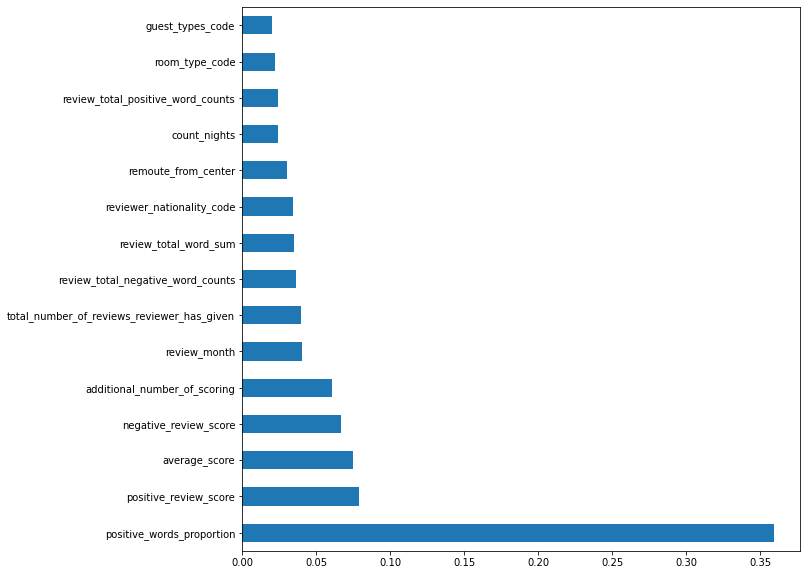

In [339]:
# самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [340]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,country_code,remoute_from_center,lang_type_code,reviewer_nationality_code,count_nights,room_type_code,guest_types_code,trip_types_code,review_total_word_sum,positive_words_proportion,negative_review_score,positive_review_score,review_month,review_year
123169,0.131667,8.3,0.012255,0.032911,0.693147,0.0,5,3.0,4,212,5,1,1,1,18,0.722222,0.0000,0.8555,3,2017
106738,0.013428,8.6,0.117647,0.081013,1.791759,0.0,1,3.0,6,31,5,2,0,1,80,0.400000,-0.7963,0.3597,1,2017
36254,0.029467,9.1,0.000000,0.103797,0.693147,0.0,1,1.0,1,213,4,2,0,1,41,1.000000,0.0000,0.9711,12,2016
36236,0.218575,7.4,0.051471,0.035443,2.397895,0.0,3,4.0,7,160,2,2,6,0,35,0.400000,-0.6369,0.8225,5,2016
20450,0.060798,9.3,0.000000,0.053165,1.098612,0.0,0,1.0,1,213,1,2,1,1,21,1.000000,0.0000,0.6249,1,2017
59504,0.256994,8.6,0.000000,0.000000,3.401197,0.0,5,7.0,4,62,1,2,1,1,0,0.500000,0.0000,0.0000,12,2015
105105,0.264081,8.2,0.000000,0.007595,1.609438,0.0,5,2.0,1,213,1,2,1,1,3,1.000000,0.0000,0.0000,8,2016
49277,0.022380,8.1,0.066176,0.058228,2.302585,0.0,0,1.0,6,101,1,7,6,0,50,0.460000,0.0000,0.7178,4,2016
59950,0.022007,8.1,0.095588,0.113924,1.386294,0.0,4,5.0,1,213,3,2,1,1,84,0.535714,-0.0795,0.9381,4,2017
117489,0.340545,8.5,0.012255,0.005063,0.693147,0.0,3,4.0,1,213,2,2,1,1,7,0.285714,0.0000,0.4939,5,2017


In [341]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [342]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [343]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished


In [344]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.400,488440
1,7.841,274649
2,7.995,374688
3,9.591,404352
4,9.581,451596
5,9.162,302161
6,8.000,317079
7,7.475,13963
8,8.591,159785
9,7.428,195089
